In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("/content/data_label_binary.csv")

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Conv1D, MaxPooling1D, Dense, Flatten, Dropout, concatenate,Reshape
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Perform feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Text'])

# Convert labels to numpy array
y = np.array(df['label'])

# Preprocessing
# We don't need to do any further preprocessing since TF-IDF vectorizer takes care of it

# Convert sparse matrix to numpy array
X = X.toarray()

# Extract features
max_features = 2000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['Text'])
sequences = tokenizer.texts_to_sequences(df['Text'])
X = pad_sequences(sequences, maxlen=100)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the input shape
input_shape = X_train.shape[1:]

# Define the RNN part of the model
rnn_input = Input(shape=input_shape)
rnn_layer = Embedding(input_dim=max_features, output_dim=64, input_length=input_shape[0])(rnn_input)
rnn_layer = LSTM(units=64, return_sequences=True)(rnn_layer)
rnn_layer = Dropout(0.2)(rnn_layer)
rnn_layer = Flatten()(rnn_layer)

# Define the CNN part of the model
cnn_input = Input(shape=input_shape)
cnn_layer = Reshape((input_shape[0], 1))(cnn_input)
cnn_layer = Conv1D(64, 3, padding='same', activation='relu')(cnn_layer)
cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
cnn_layer = Dropout(0.2)(cnn_layer)
cnn_layer = Flatten()(cnn_layer)

# Combine the RNN and CNN layers
concat_layer = concatenate([rnn_layer, cnn_layer])

# Add a dense layer and an output layer
dense_layer = Dense(32, activation='relu')(concat_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# Define the model and compile it
model = Model(inputs=[rnn_input, cnn_input], outputs=[output_layer])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit([X_train, X_train], y_train, validation_data=([X_test, X_test], y_test), epochs=10, batch_size=32)


Epoch 1/10
25/25 [==============================] - 5s 93ms/step - loss: 3.4869 - accuracy: 0.5490 - val_loss: 0.9743 - val_accuracy: 0.6482
Epoch 2/10
25/25 [==============================] - 2s 93ms/step - loss: 0.7491 - accuracy: 0.6420 - val_loss: 0.6619 - val_accuracy: 0.5628
Epoch 3/10
25/25 [==============================] - 2s 70ms/step - loss: 0.6486 - accuracy: 0.6256 - val_loss: 0.6605 - val_accuracy: 0.5528
Epoch 4/10
25/25 [==============================] - 2s 69ms/step - loss: 0.6241 - accuracy: 0.6143 - val_loss: 0.6343 - val_accuracy: 0.5879
Epoch 5/10
25/25 [==============================] - 2s 70ms/step - loss: 0.6214 - accuracy: 0.6181 - val_loss: 0.6416 - val_accuracy: 0.6030
Epoch 6/10
25/25 [==============================] - 2s 71ms/step - loss: 0.6429 - accuracy: 0.6231 - val_loss: 0.6693 - val_accuracy: 0.5829
Epoch 7/10
25/25 [==============================] - 2s 71ms/step - loss: 0.6033 - accuracy: 0.6281 - val_loss: 0.6392 - val_accuracy: 0.5879
Epoch 8/10
25

In [12]:
import urllib.request

url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz'
file_name = 'cc.id.300.vec.gz'

urllib.request.urlretrieve(url, file_name)


('cc.id.300.vec.gz', <http.client.HTTPMessage at 0x7fb1baa87820>)

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import gensim
from tqdm import tqdm


# Perform feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Text'])

# Convert labels to numpy array
y = np.array(df['label'])

# Preprocessing
# We don't need to do any further preprocessing since TF-IDF vectorizer takes care of it

# Convert sparse matrix to numpy array
X = X.toarray()

# Extract features
max_features = 2000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['Text'])
sequences = tokenizer.texts_to_sequences(df['Text'])
X = pad_sequences(sequences, maxlen=100)

# Feature expansion
feature_ef = vectorizer.get_feature_names()
model_ef = gensim.models.KeyedVectors.load_word2vec_format('/content/cc.id.300.vec.gz')

def feature_expansion(df, feature, max_distance=0.6):
    for col in tqdm(df.columns): #loop per kolom
        if col not in feature:
            try: 
                sim_words = model_ef.similar_by_word(col, topn=10) #mencari Similarity
            except:
                sim_words = []
            for sim_word, sim_score in sim_words:
                if sim_word in feature and sim_score >= max_distance:
                    # check if the similar word has a non-zero value in the DataFrame
                    # and the column is not already assigned a non-zero value
                    if df[sim_word].any() and not df[col].any():
                        # assign the non-zero value of the similar word to the current column
                        df.loc[df[sim_word] != 0, col] = df[sim_word]
    return df

df = feature_expansion(df, feature_ef)

vectorizer_ef = TfidfVectorizer(vocabulary=feature_ef)
X_ef = vectorizer_ef.fit_transform(df['Text'])

X_ef = X_ef.toarray()
X = np.concatenate([X, X_ef], axis=1)

# Split the data into training and testing sets
X_train, Ex_X_test, y_train,Ex_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

input_shape = X_train.shape[1:]

# Define the RNN part of the model
rnn_input = Input(shape=input_shape)
rnn_layer = Embedding(input_dim=max_features, output_dim=64, input_length=input_shape[0])(rnn_input)
rnn_layer = LSTM(units=64, return_sequences=True)(rnn_layer)
rnn_layer = Dropout(0.2)(rnn_layer)
rnn_layer = Flatten()(rnn_layer)

# Define the CNN part of the model
cnn_input = Input(shape=input_shape)
cnn_layer = Reshape((input_shape[0], 1))(cnn_input)
cnn_layer = Conv1D(64, 3, padding='same', activation='relu')(cnn_layer)
cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
cnn_layer = Dropout(0.2)(cnn_layer)
cnn_layer = Flatten()(cnn_layer)

# Combine the RNN and CNN layers
concat_layer = concatenate([rnn_layer, cnn_layer])

# Add a dense layer and an output layer
dense_layer = Dense(32, activation='relu')(concat_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# Define the model and compile it
ex_model = Model(inputs=[rnn_input, cnn_input], outputs=[output_layer])
ex_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
ex_model.fit([X_train, X_train], y_train, validation_data=([Ex_X_test, Ex_X_test], Ex_y_test), epochs=10, batch_size=32)



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 1/10
25/25 [==============================] - 94s 4s/step - loss: 2.7471 - accuracy: 0.5829 - val_loss: 0.8563 - val_accuracy: 0.6080
Epoch 2/10
25/25 [==============================] - 92s 4s/step - loss: 0.7850 - accuracy: 0.6118 - val_loss: 0.6855 - val_accuracy: 0.5779
Epoch 3/10
25/25 [==============================] - 95s 4s/step - loss: 0.6839 - accuracy: 0.6106 - val_loss: 0.6743 - val_accuracy: 0.5779
Epoch 4/10
25/25 [==============================] - 93s 4s/step - loss: 0.6883 - accuracy: 0.6106 - val_loss: 0.7367 - val_accuracy: 0.5779
Epoch 5/10
25/25 [==============================] - 94s 4s/step - loss: 0.7026 - accuracy: 0.6106 - val_loss: 0.6817 - val_accuracy: 0.5779
Epoch 6/10
25/25 [==============================] - 94s 4s/step - loss: 0.6619 - accuracy: 0.6106 - val_loss: 0.6845 - val_accuracy: 0.5779
Epoch 7/10
25/25 [==============================] - 95s 4s/step - loss: 0.6515 - accuracy: 0.6106 - val_loss: 0.6924 - val_accuracy: 0.5779
Epoch 8/10
25/25 [==

In [16]:
from sklearn.metrics import confusion_matrix

# Predict using the without expanded feature model
y_pred_1 = model.predict([X_test, X_test])
y_pred_1 = (y_pred_1 > 0.5).astype(int)

# Predict using the with expanded feature model
y_pred_2 = ex_model.predict([Ex_X_test, Ex_X_test])
y_pred_2 = (y_pred_2 > 0.5).astype(int)

# Generate the confusion matrices for both models
cm_1 = confusion_matrix(y_test, y_pred_1)
cm_2 = confusion_matrix(Ex_y_test, y_pred_2)

print("Confusion matrix for without expanded feature model:\n", cm_1)
print("Confusion matrix for with expanded feature model:\n", cm_2)


7/7 [==============================] - 4s 596ms/step
Confusion matrix for without expanded feature model:
 [[111   4]
 [ 78   6]]
Confusion matrix for with expanded feature model:
 [[115   0]
 [ 84   0]]


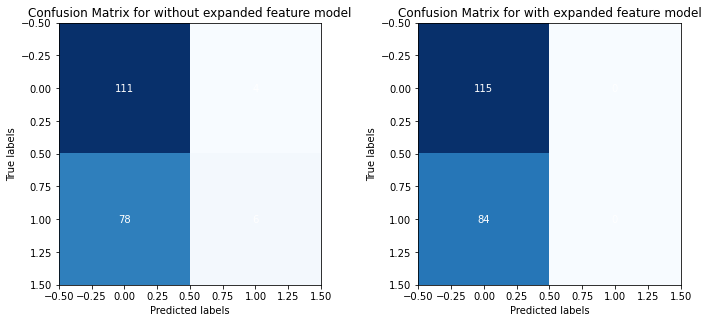

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot confusion matrix for model 1
ax[0].imshow(cm_1, cmap='Blues')
ax[0].set_title('Confusion Matrix for without expanded feature model')
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
for i in range(cm_1.shape[0]):
    for j in range(cm_1.shape[1]):
        ax[0].text(j, i, cm_1[i, j], ha='center', va='center', color='white')

# Plot confusion matrix for model 2
ax[1].imshow(cm_2, cmap='Blues')
ax[1].set_title('Confusion Matrix for with expanded feature model')
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
for i in range(cm_2.shape[0]):
    for j in range(cm_2.shape[1]):
        ax[1].text(j, i, cm_2[i, j], ha='center', va='center', color='white')

plt.tight_layout()
plt.show()
